### Price rise = 1 / Price drop = -1

In [1]:
import numpy as np
import warnings
from pandas_datareader import data as pdr
import yfinance as yf
import datetime as dt
from yahoo_fin import stock_info as si
import pandas as pd
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")
yf.pdr_override()

In [2]:
num_of_years = 1
start = dt.date.today() - dt.timedelta(days = int(365.25*num_of_years))
end = dt.date.today()

In [ ]:
# df = pd.read_csv('data/mktcap.csv', index_col=0)
# df = df[df['mktcap']>0]
#
# Use csv file from China
df = pd.read_csv('data/hk_stock_full.csv', header=None)
df = df.rename(columns={0: 'stock'})

In [ ]:
df

In [ ]:
def stock_begin_timegap(stock):
    num_of_years = 1
    start = dt.date.today() - dt.timedelta(days = int(365.25*num_of_years))
    try:
        stock_start = yf.download(stock, start=start).index[0]
        return (stock_start - pd.to_datetime(start)).days
    except:
        return 10000

In [ ]:
df['gap'] = df['stock'].apply(stock_begin_timegap)

In [ ]:
df

In [ ]:
stock_df = df[df['gap'] <= 5]

In [ ]:
stock_df.count()

In [ ]:
stock_df.to_csv('data/stock_qualified.csv')

### Find correlation

In [ ]:
stock_df = pd.read_csv('data/stock_qualified.csv', index_col=0)

In [ ]:
%%time
tickers = stock_df['stock'].to_list()
dataset = pdr.get_data_yahoo(tickers, start, end)['Adj Close']

In [ ]:
dataset.info()

In [ ]:
dataset.to_csv('data/all_stock_close.csv')

In [ ]:
dataset.head(3)

In [ ]:
dataset['']

### Use close on all stocks to compile result

In [3]:
dataset = pd.read_csv('data/all_stock_close.csv')
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', drop=True, inplace=True)

In [4]:
prevday_returns = np.log(dataset.shift(1)/dataset.shift(2))
today_returns = np.log(dataset/dataset.shift(1))

In [5]:
def binary_rise_drop(x):
    if x < 0:
        return 1
    elif x > 0:
        return -1
    else:
        return 0

In [6]:
prevday_returns = prevday_returns.applymap(binary_rise_drop)
today_returns = today_returns.applymap(binary_rise_drop)

In [7]:
stocks_prev = prevday_returns.columns.to_list()
stocks_today = today_returns.columns.to_list()

In [8]:
new_col = ['{}.prev'.format(c) for c in stocks_prev]
prevday_returns.columns = new_col

In [9]:
comb_df = pd.concat([prevday_returns, today_returns], axis=1)

In [10]:
%%time
print('\nCorrelation Matrix')
corr_matrix = comb_df.corr()
# print(corr_matrix)


Correlation Matrix
CPU times: user 8.83 s, sys: 19.5 ms, total: 8.85 s
Wall time: 8.84 s


In [11]:
corr_matrix_corrected = corr_matrix.loc[new_col, stocks_today]

### What to drop

In [12]:
sorted_corr = corr_matrix_corrected.abs().unstack().sort_values(ascending=False)
sorted_corr.shape

(4713241,)

In [13]:
sorted_corr.head(10)

0269.HK  1889.HK.prev    0.449707
0521.HK  0521.HK.prev    0.349398
0661.HK  0661.HK.prev    0.341892
8226.HK  8226.HK.prev    0.341414
3883.HK  3868.HK.prev    0.341401
1051.HK  1051.HK.prev    0.341353
8311.HK  0073.HK.prev    0.332205
1250.HK  1375.HK.prev    0.327011
1217.HK  1217.HK.prev    0.324464
0885.HK  0885.HK.prev    0.324082
dtype: float64

### Analyze the top pair

In [14]:
comb_df['1889.HK.prev'].corr(comb_df['0269.HK'])

-0.4497070090353939

### Charting

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
import yfinance as yf 
import talib as TA
from datetime import datetime

from dateutil.relativedelta import relativedelta

In [16]:
stock1 = '1889.HK'
stock2 = '0269.HK'
df1 = yf.download(stock1, start=start)
df1['Date'] = df1.index
df1['Date'] = df1['Date'].apply(mdates.date2num)
df2 = yf.download(stock2, start=start)
df2['Date'] = df2.index
df2['Date'] = df2['Date'].apply(mdates.date2num)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


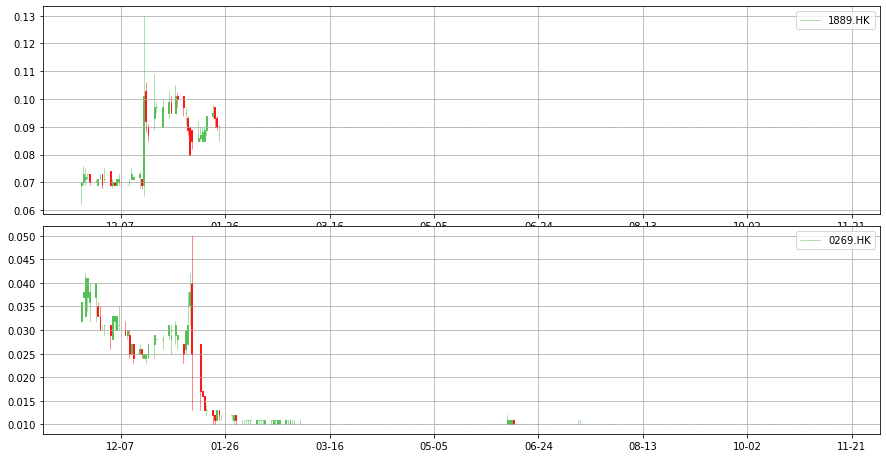

In [17]:
ohlc_seq = ['Date', 'Open', 'High', 'Low', 'Close']
fig = plt.figure(figsize = (15,20))
# fig.suptitle('{}.HK {}'.format(label, start_date.year), fontsize=18)
current_row = 0
ax_height = 3
ax0 = plt.subplot2grid((15,4), (current_row,0), rowspan=ax_height, colspan=4)
ax0.grid(True)
candlestick_ohlc(ax0, df1[ohlc_seq].values, width=.4, colorup='#53c156', colordown='#ff1717')
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax0.legend([stock1])
#
current_row = current_row + ax_height
ax_height = 3
ax1 = plt.subplot2grid((15,4), (current_row,0), rowspan=ax_height, colspan=4, sharex=ax0)
ax1.grid(True)
candlestick_ohlc(ax1, df2[ohlc_seq].values, width=.4, colorup='#53c156', colordown='#ff1717')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.legend([stock2])

### Zoom into a period

In [18]:
chart_start = '12/01/2019'
chart_end = '12/31/2019'

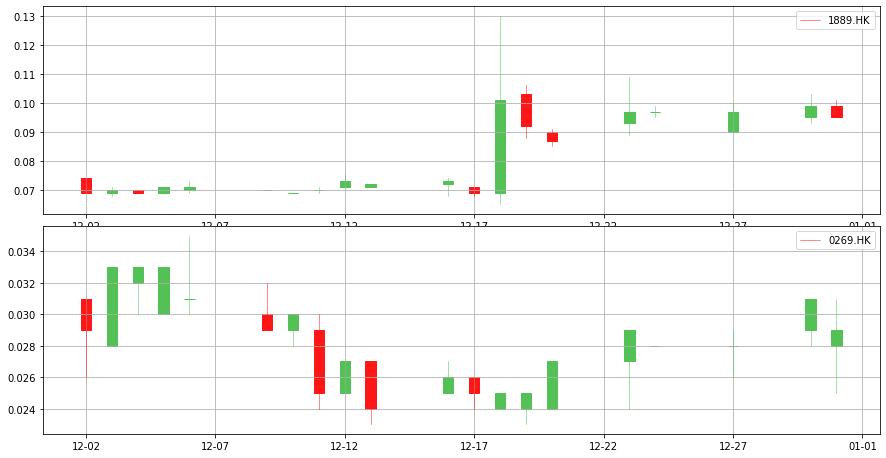

In [19]:
ohlc_seq = ['Date', 'Open', 'High', 'Low', 'Close']
fig = plt.figure(figsize = (15,20))
# fig.suptitle('{}.HK {}'.format(label, start_date.year), fontsize=18)
current_row = 0
ax_height = 3
ax0 = plt.subplot2grid((15,4), (current_row,0), rowspan=ax_height, colspan=4)
ax0.grid(True)
candlestick_ohlc(ax0, df1.loc[chart_start:chart_end,ohlc_seq].values, width=.4, colorup='#53c156', colordown='#ff1717')
ax0.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax0.legend([stock1])
#
current_row = current_row + ax_height
ax_height = 3
ax1 = plt.subplot2grid((15,4), (current_row,0), rowspan=ax_height, colspan=4, sharex=ax0)
ax1.grid(True)
candlestick_ohlc(ax1, df2.loc[chart_start:chart_end,ohlc_seq].values, width=.4, colorup='#53c156', colordown='#ff1717')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.legend([stock2])

### MOre analysis

In [21]:
prev_stock = '{}.prev'.format(stock1)
now_stock = stock2
compare_df = pd.concat([prevday_returns[prev_stock], today_returns[now_stock]], axis=1)
print(compare_df[compare_df[prev_stock]>0].count())
print(compare_df[(compare_df[prev_stock]>0) & (compare_df[now_stock]>0)].count())
print(compare_df[(compare_df[prev_stock]>0) & (compare_df[now_stock]<=0)].count())

1889.HK.prev    19
0269.HK         19
dtype: int64
1889.HK.prev    4
0269.HK         4
dtype: int64
1889.HK.prev    15
0269.HK         15
dtype: int64
